In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import SIPKSEvolve as sip
from utils import reparameterize
from tqdm import tqdm


/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [4]:
# evolve (adapt dt)
# system parameters
L_full = 1000.0   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
epsilon = 1e-1  # important
r = 1e-2        # important
lbd_spl = 20.0  # important
kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
lbd_max = -1 / k * np.log(eps / k / kappa)
print(f'Emerging scales: {lbd_spl/2 = :.2f}, argmax v_M = {lbd_max:.2f}, {lbd_spl = :.2f}')

# initial conditions
mu = 10.0  # part of lbd_spl to start at
sig = 5.0       # spread

# # evolution parameters
n_steps = 100_000
dt = 1e2
print(f'Evolving on [0, {n_steps * dt:.0e}] with {dt = }, saving {n_steps} sample points. ')

np.random.seed(311)

Nmax = 2 * int(L_full / lbd_max)

t_range, lbd_vect_t, adj_matr_t = sip.evolve_adapt_timestep(Nmax, L_full, Drho, Dc, T, epsilon, r, lbd_spl, n_steps, dt, ini_dist_type='gauss', mu=mu, sig=sig, maxiter=6_000)

/usr/lib64/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Emerging scales: lbd_spl/2 = 10.00, argmax v_M = 13.58, lbd_spl = 20.00
Evolving on [0, 1e+07] with dt = 100.0, saving 100000 sample points. 


Worst case timer:   0%|          | 0/6000 [00:00<?, ?it/s]

Worst case timer:   0%|          | 0/6000 [00:00<?, ?it/s]


IndexError: index 0 is out of bounds for axis 0 with size 0

20


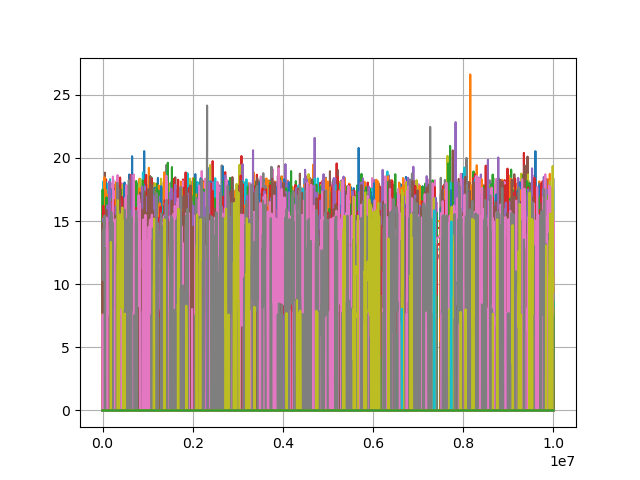

In [8]:
# plot solution 
fig, ax = plt.subplots()
# assert np.all(np.isclose(np.sum(lbd_vect_t, axis=0), L_full))
Nmax = np.shape(lbd_vect_t)[0]
for i in range(min(Nmax, 150)):
    # ax.plot(t_range, np.abs(lbd_vect_t[i, :]-lbd_vect_t[i, 0]))
    ax.plot(t_range[::1], lbd_vect_t[i, ::1])
    # ax.plot(t_range, np.cumsum(lbd_vect_t, axis=0)[i, :])
# ax.plot(t_range, np.sum(lbd_vect_t, axis=0))
ax.grid()
# ax.set_xscale('log')
# ax.set_yscale('log')
print(len(np.where(np.any(lbd_vect_t > 0.001, axis = 1))[0]))
plt.show()

In [6]:
# evolve (adapt dt) - parameter sweep

# system parameters
# L_full = 45.0   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
epsilon = 1e-1  # important
r = 1e-2        # important
lbd_spl = 15.0  # important

# initial conditions
mu_fact = 0.65  # part of lbd_spl to start at
sig = 4.0       # spread

# evolution parameters
n_steps = 100_000
dt = 1e2        # true dt is now adaptive. saving only at multiples of dt

kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
lower_stab = -1/k * np.log(eps / k / kappa)
# print(f'{lower_stab = }')
# lbd_spl_range = np.linspace(lower_stab + 2, lower_stab + 10, 20, endpoint=True)

# lbd_spl_range = np.linspace(15.0, 17.0, 7, endpoint=True)
# sig_range     = [1.0, 5.0]
L_full_range = np.logspace(2.2, 2.11, 1, endpoint=True)

# params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt) for lbd_spl in lbd_spl_range for epsilon in epsilon_range for sig in sig_range]
# params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt) for lbd_spl in lbd_spl_range for sig in sig_range]
# params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact / lbd_spl * L_full / 3, sig, n_steps, dt) for lbd_spl in lbd_spl_range]
params_list = [(3 * int(L_full / lower_stab), L_full, Drho, Dc, T, epsilon, r, lbd_spl, n_steps, dt) for L_full in L_full_range]

num_repeat = 1

for i, params in enumerate(params_list):#tqdm(enumerate(params_list), total=len(params_list)):
    for j in range(num_repeat):
        # print(f'{i + 1} / {len(params_list)}, {j + 1} / {num_repeat}')
        t_range, lbd_vect_t, adj_matr_t = sip.evolve_adapt_timestep_smart(*params, ini_dist_type='chaos', mu=None, sig=None, save_bool=True, tqdm_bool=True, maxiter=100_000, seed=125 + j + 1000 * i, verbose=False)
        # if np.sum(lbd_vect_t[:,-1] > 0) < 11:
        #     print('!!!!')
        #     t_range_broken, lbd_vect_t_broken, adj_matr_t_broken = t_range.copy(), lbd_vect_t.copy(), adj_matr_t.copy()
        # if save_bool:
        #     L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt = params
        #     # np.save(f'SIP_data/lbdvecttA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}_{j}.npy', lbd_vect_t)
        #     # np.save(f'SIP_data/adjmatrtA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}_{j}.npy', adj_matr_t)
        #     np.save(f'/scratch/n/Natan.Dominko/SIP_data/lbdvecttA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}_{j}.npy', lbd_vect_t)
        #     np.save(f'/scratch/n/Natan.Dominko/SIP_data/adjmatrtA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}_{j}.npy', adj_matr_t)


Worst case timer:   0%|          | 0/100000 [00:00<?, ?it/s]/usr/lib64/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
Worst case timer:  30%|███       | 30370/100000 [05:01<11:31, 100.65it/s]


In [5]:
t_range, lbd_vect_t, adj_matr_t

(9998895.644160667, False, 4)

In [ ]:
lbd_vect_ini, adj_matr_ini = sip.get_initials(3 * int(L_full_range[0] / lower_stab), L_full_range[0], Drho, Dc, T, epsilon, r, lbd_spl, mu=None, sig=None, ini_dist_type='chaos')

In [ ]:
print(lbd_vect_ini)
print(sip.fix_negative_adaptive(lbd_vect_ini, adj_matr_ini))

[11.41568474  8.47352175 14.5419044   8.16377407 14.06177543  8.38248675
 10.05760633  7.2015271  12.37345002 13.63494381  1.81972976  9.25350696
  9.41760465  9.458921   10.56682094  9.66606154  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
(array([11.41568474,  8.47352175, 14.5419044 ,  8.16377407, 14.06177543,
        8.38248675, 10.05760633,  7.2015271 , 12.37345002, 13.63494381,
        1.81972976,  9.25350696,  9.41760465,  9.458921  , 10.56682094,
        9.66606154,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ]), <33x33 sparse matrix of type '<class 'numpy.int64'>'
	with 46 stored elements in Compressed Sparse Row format>)


In [ ]:
np.sum(lbd_vect)

2.1999999999832536

In [ ]:
from os import listdir
filenames = [f for f in listdir('/scratch/n/Natan.Dominko/SIP_data')]
print(filenames)

[]


In [ ]:
# # read off dalbd_spls_tilde and perform 'observations'
# # from os import listdir
# # filenames = [f for f in listdir('evol_data/') if (f[:9] == "lbdvectt_")]

# # system parameters
# # L_full = 100   # system size
# Drho = 0.1      # fixed
# Dc = 1.0        # fixed 
# T = 5.0         # fixed
# epsilon = 1e-1  # important
# r = 1e-2        # important
# lbd_spl = 20.0  # important

# # initial conditions
# mu_fact = 0.65  # part of lbd_spl to start at
# sig = 4.0       # spread

# # evolution parameters
# n_steps = 100_000
# dt = 1e2        # true dt is now adaptive. saving only at multiples of dt

# kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
# lower_stab = -1/k * np.log(eps / k / kappa)
# print(f'{lower_stab = }')
# # lbd_spl_range = np.linspace(lower_stab + 6, lower_stab + 10, 20, endpoint=True)

# # lbd_spl_range = np.linspace(15.0, 17.0, 7, endpoint=True)
# # sig_range     = [1.0, 5.0]
# L_full_range = np.logspace(3, 2, 5, endpoint=True)

# # params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt) for lbd_spl in lbd_spl_range for epsilon in epsilon_range for sig in sig_range]
# # params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt) for lbd_spl in lbd_spl_range for sig in sig_range]
# # params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact / lbd_spl * L_full / 3, sig, n_steps, dt) for lbd_spl in lbd_spl_range]
# params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact * lbd_spl, sig, n_steps, dt) for L_full in L_full_range]

# epsilons, lbd_spls, L_fulls, sigs, color_values, color_values2, color_values3 = [],[],[],[],[],[],[]

# num_repeat = 100

# for i, params in tqdm(enumerate(params_list), total=len(params_list)):
#     for j in range(num_repeat):
#         L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt = params
#         # lbd_vect_t = np.load(f'SIP_data/lbdvecttA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}.npy')
#         # lbd_vect_t = np.load(f'SIP_data/lbdvecttA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}_{j}.npy')
#         lbd_vect_t = np.load(f'/scratch/n/Natan.Dominko/SIP_data/lbdvecttA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}_{j}.npy')
#         # adj_matr_t = np.load(f'/scratch/n/Natan.Dominko/SIP_data/adjmatrtA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}.npy', allow_pickle=True)
#         t_range = np.arange(0, n_steps*dt, dt)

#         # n_bins_x = 30
#         # bin_edges_x = np.linspace(0, 1.2 * lbd_spl, n_bins_x + 1, endpoint=True)
#         # bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])

#         # find true last time
#         last_ind = np.max(np.where(np.any(lbd_vect_t > 0, axis=0))[0])
#         last_time = t_range[last_ind]
#         try:
#             equi_time = t_range[np.max(np.where(np.abs(np.diff(np.sum(lbd_vect_t > 0, axis=0))))[0])]
#         except:
#             equi_time = 0.0
        
#         # end_vals = lbd_vect_t[lbd_vect_t[:, last_ind] > 0, last_ind]
#         # end_hist, _ = np.histogram(end_vals, bins=bin_edges_x, density=True)
        
#         # mean = np.trapz(end_hist * bin_center_x, bin_center_x)
#         # stdev= np.sqrt(np.trapz(end_hist * (mean - bin_center_x)**2, bin_center_x)) / lbd_spl
#         # print(f'{epsilon = :.2e}, {lbd_spl = :.2f}, {stdev}')

#         epsilons.append(epsilon)    
#         lbd_spls.append(lbd_spl)
#         L_fulls.append(L_full)
#         sigs.append(sig)
#         color_values.append(equi_time)
#         color_values2.append(last_time)
#         # color_values2.append(stdev)
#             # color_values3.append(end_hist)



lower_stab = 13.581912523491635


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


In [ ]:
def values2rgb(arr):
    maxval = max(arr)
    return [(el/maxval, 0, 1 - el/maxval, 0.3) for el in arr]

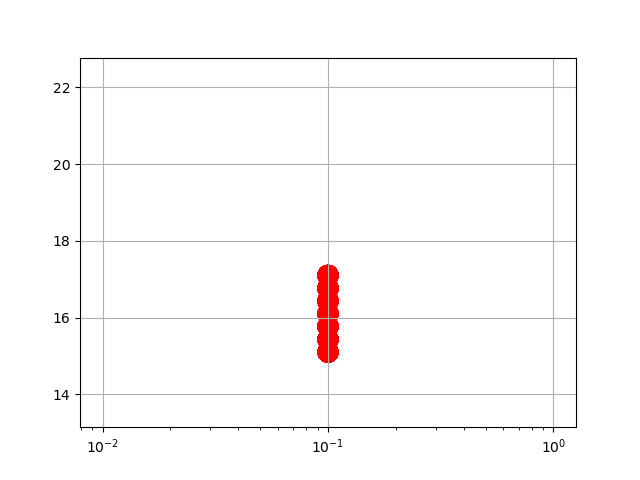

In [ ]:
from scipy.optimize import fsolve
fig, ax = plt.subplots()
scatter = ax.scatter(epsilons, [lbd_spls[i] + sigs[i]/10 for i in range(len(epsilons))], c=values2rgb(color_values2), s=200)
lower_stab_array = []
scale_argument = []
for epsilon in epsilons:
    kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
    lower_stab_array.append(-1/k * np.log(eps / k / kappa))
    scale_argument.append(fsolve(lambda x: kappa * np.exp(-k * x) - kappa * np.exp(-k * x / 2) + eps * x / 2, 30))
ax.plot(epsilons, lower_stab_array, 'g-', label='argmax v_M')
ax.plot(epsilons, scale_argument, 'k-', label='scale argument')
ax.grid()
ax.set_xscale('log')
plt.show()


lower_stab = 13.581912523491635
scale_argument = [22.33755271]


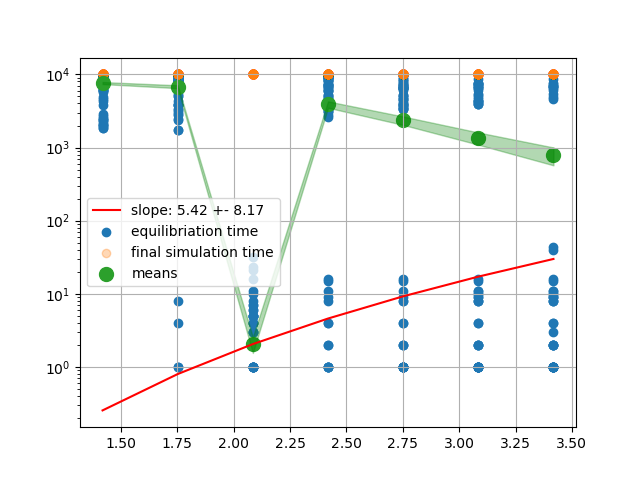

errs = array([[ 66.71669462, -49.01368408],
       [-49.01368408,  36.00828671]])


In [ ]:
from scipy.optimize import fsolve
kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
lower_stab = -1/k * np.log(eps / k / kappa)
print(f'{lower_stab = }')
print(f'scale_argument = {(fsolve(lambda x: kappa * np.exp(-k * x) - kappa * np.exp(-k * x / 2) + eps * x / 2, 30))}')
fig, ax = plt.subplots()
lbd_spls = np.array(lbd_spls)
lbd_spls_tilde = lbd_spls[::num_repeat] - lower_stab
tms_means = np.array([np.mean(np.array(color_values[i*num_repeat:(i+1)*num_repeat])) for i in range(len(color_values)//num_repeat)])
tms_vars = np.array([np.var(np.array(color_values[i*num_repeat:(i+1)*num_repeat])) for i in range(len(color_values)//num_repeat)])
# ax.scatter(-L_full/lbd_spls+L_full/lower_stab, color_values, label='equilibriation time')
# ax.scatter(-L_full/lbd_spls+L_full/lower_stab, color_values2, alpha=0.3, label='final simulation time')
# ax.scatter(-L_full/lbd_spls[::num_repeat]+L_full/lower_stab, tms_means, s=100, label='means')

ax.scatter(lbd_spls - lower_stab, color_values, label='equilibriation time')
ax.scatter(lbd_spls - lower_stab, color_values2, alpha=0.3, label='final simulation time')
ax.scatter(lbd_spls_tilde, tms_means, s=100, label='means')
ax.fill_between(lbd_spls_tilde, tms_means-np.sqrt(tms_vars/num_repeat), tms_means+np.sqrt(tms_vars/num_repeat), color='g', alpha=0.3)

from scipy.optimize import curve_fit
slice = np.arange(len(lbd_spls_tilde))[:14]
(a, b), errs = curve_fit(lambda x, _a, _b :_a*x + _b, np.log(lbd_spls_tilde)[slice], np.log(tms_means)[slice], p0=(-1.0, 10.0), sigma=np.sqrt(tms_vars[slice]/num_repeat))
ax.plot(lbd_spls_tilde[slice], np.exp(1)**(a * np.log(lbd_spls_tilde)[slice] + b), 'r', label=f'slope: {a:.2f} +- {np.sqrt(errs[0, 0]):.2f}')
# ax.axvline(fsolve(lambda x: kappa * np.exp(-k * x) - kappa * np.exp(-k * x / 2) + eps * x / 2, 30)[0]-lower_stab, 0, 1, c='k', label='chaos existence') 
ax.legend()
ax.grid()
# ax.set_xscale('log')
ax.set_yscale('log')
plt.show()
print(f'{errs = }')

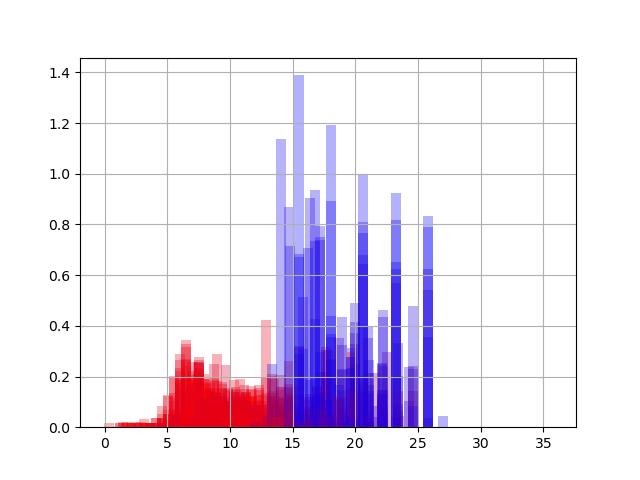

In [ ]:
fig, ax = plt.subplots()
for i in range(0, len(epsilons)):
    n_bins_x = 30
    bin_edges_x = np.linspace(0, 1.2 * lbd_spls[i], n_bins_x + 1, endpoint=True)
    bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])

    ax.bar(bin_center_x, color_values3[i], color=values2rgb(color_values2)[i], label=f'epsilon = {epsilons[i]}, lbd_spl = {lbd_spls[i]}, sig = {sigs[i]}')
ax.grid()
plt.show()

In [ ]:
# evolve hard split
# system parameters
L_full = 42.0   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
epsilon = 1e-1  # important
lbd_spl = 20.0  # important
kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
lbd_max = -1 / k * np.log(eps / k / kappa)
print(f'Emerging scales: {lbd_spl/2 = :.2f}, argmax v_M = {lbd_max:.2f}, {lbd_spl = :.2f}')

# initial conditions
mu_fact = 1.0  # part of lbd_spl to start at
sig = 3.0       # spread
# lbd_vect_ini, adj_matr_ini = get_initials(L_full, lbd_spl, mu_fact, sig, Nmax_fact=8)
# print(lbd_vect_ini)
# print(adj_matr_ini)

# # evolution parameters
n_steps = 20_000
dt = 1e2
print(f'Evolving on [0, {n_steps * dt:.0e}] with {dt = }, saving {n_steps} sample points. ')

np.random.seed(300001)

_, _, _,t_range, lbd_vect_t, adj_matr_t = sip.evolve_adapt_timestep_hard_split(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact / lbd_spl * L_full / 3, sig, n_steps, dt, Nmax_fact=3, maxiter=6_000)

Emerging scales: lbd_spl/2 = 10.00, argmax v_M = 13.58, lbd_spl = 20.00
Evolving on [0, 2e+06] with dt = 100.0, saving 20000 sample points. 


Worst case timer:   0%|          | 0/6000 [00:00<?, ?it/s]/usr/lib64/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
Worst case timer:   5%|▌         | 328/6000 [00:06<01:48, 52.05it/s]


In [ ]:
# equilibriation time sweep

# system parameters
# L_full = 100   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
epsilon = 1e-1  # important
r = 1e-2        # important
lbd_spl = 15.0  # important

# evolution parameters
n_steps = 1
dt = 1e10     # true dt is now adaptive, only thing that matters is total time

L_full_range = np.logspace(3.0, 2.0, 1, endpoint=True)

params_list = [(3*int(L_full/lbd_spl), L_full, Drho, Dc, T, epsilon, r, lbd_spl, n_steps, dt) for L_full in L_full_range]

num_repeat = 3

end_time_array = np.zeros((len(params_list), num_repeat), dtype=float)
end_bool_array = np.zeros((len(params_list), num_repeat), dtype=bool)
end_N_array    = np.zeros((len(params_list), num_repeat), dtype=int)

for i, params in enumerate(params_list):
    for j in (range(num_repeat)):
        try:
            end_time_array[i,j], end_bool_array[i,j], end_N_array[i,j] = sip.evolve_adapt_timestep_equi_time(
                *params, 
                ini_dist_type='chaos', 
                mu=None, 
                sig=None, 
                tqdm_bool=True, 
                maxiter=1_000_000, 
                seed=4111*i + 121*j + 111)
        except:
            print("!")
            end_time_array[i,j] = dt * n_steps
            end_bool_array[i,j] = False
            end_N_array[i,j] = 0


Worst case timer:   0%|          | 0/1000000 [00:00<?, ?it/s]/usr/lib64/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
Worst case timer:   0%|          | 242/1000000 [00:02<2:28:01, 112.57it/s]


!


Worst case timer:   0%|          | 326/1000000 [00:03<2:37:17, 105.92it/s]

!


In [ ]:
np.savez('test.npz', end_time_array=end_time_array, end_bool_array=end_bool_array, end_N_array=end_N_array)

In [ ]:
L_fulls = np.load("/scratch/n/Natan.Dominko/equi_time_slurm/L_fulls.npy")
color_values = np.load("/scratch/n/Natan.Dominko/equi_time_slurm/last_times.npy")
color_values2 = np.load("/scratch/n/Natan.Dominko/equi_time_slurm/time_successs.npy")
L_full
# system parameters
# L_full = 100   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
epsilon = 1e-1  # important
r = 1e-2        # important
lbd_spl = 20.0  # important

# initial conditions
mu_fact = 0.75  # part of lbd_spl to start at
sig = 5.0       # spread

# evolution parameters
n_steps = 10_000
dt = 1e5        # true dt is now adaptive anyway

kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
lower_stab = -1/k * np.log(eps / k / kappa)

L_full_range = np.logspace(3.5, 2.5, 11, endpoint=True)

params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt) for L_full in L_full_range]

num_repeat = 600


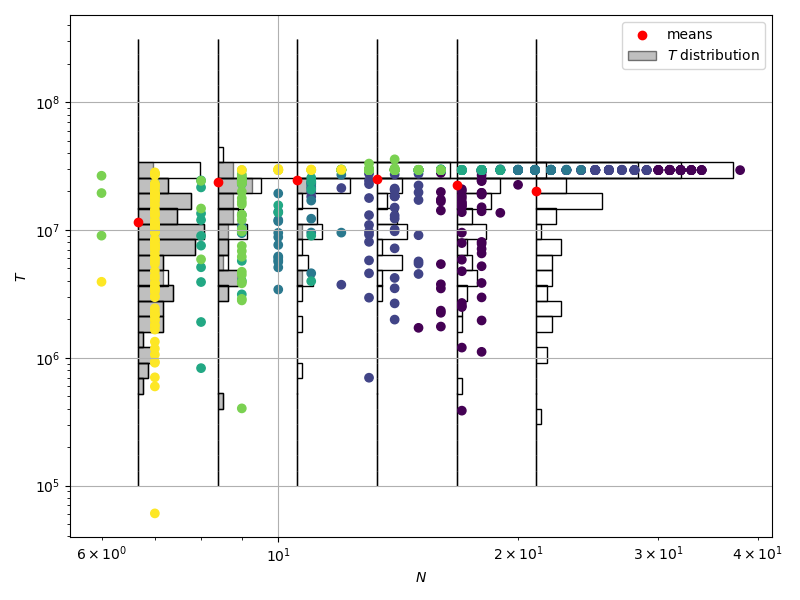

In [ ]:
n_sweep = 6
n_repeat = 5
n_jobs = 20
end_time_array_full = np.zeros((n_sweep, n_repeat * n_jobs))
end_bool_array_full = np.zeros((n_sweep, n_repeat * n_jobs))
end_N_array_full = np.zeros((n_sweep, n_repeat * n_jobs))

lbd_spl = 15
L_full_range = np.logspace(2.5, 2, n_sweep, endpoint=True)

for i in range(n_jobs):
    file = np.load(f"/scratch/n/Natan.Dominko/equi_time_sweep_slurm/outfiles/equi_time_results_{i+1}.npz")
    end_time_array = file['end_time_array']
    end_bool_array = file['end_bool_array']
    end_N_array = file['end_N_array']
    end_time_array_full[:, n_repeat*i:n_repeat*(i+1)] = end_time_array
    end_bool_array_full[:, n_repeat*i:n_repeat*(i+1)] = end_bool_array
    end_N_array_full[:, n_repeat*i:n_repeat*(i+1)] = end_N_array


fig, ax = plt.subplots(figsize=(8,6))
for i in range(np.shape(end_time_array_full)[0]):
    mask = np.logical_and(end_time_array_full[i,:]>1e3, end_bool_array_full[i,:])
    _factor = 1000
    bin_edges = np.logspace(5, 8.5, 30)
    bin_centers = np.sqrt(bin_edges[1:]*bin_edges[:-1])
    ax.barh(bin_centers, width=np.histogram(end_time_array_full[i,mask], bins=bin_edges)[0]*L_full_range[i]/_factor, left=L_full_range[i]/lbd_spl, height=np.diff(bin_edges), color='grey', alpha=0.5, edgecolor='k', zorder=-10, label='$T$ distribution' if i==0 else '')
    ax.barh(bin_centers, width=np.histogram(end_time_array_full[i, :], bins=bin_edges)[0]*L_full_range[i]/_factor, left=L_full_range[i]/lbd_spl, height=np.diff(bin_edges), color=(0, 0, 1, 0), edgecolor='k', zorder=-10)

ax.scatter(end_N_array_full, end_time_array_full, c=np.repeat(np.arange(n_sweep).T, n_repeat*n_jobs))
ax.scatter(L_full_range/lbd_spl, np.mean(end_time_array_full, axis=1), c='r', label='means')
# ax.fill_between(L_fulls_tilde/lbd_spl, tms_means-np.sqrt(tms_vars/num_repeat), tms_means+np.sqrt(tms_vars/num_repeat), color='r', alpha=0.3)

# from scipy.optimize import curve_fit
# slice = np.arange(len(L_fulls_tilde))[:11]
# (a, b), errs = curve_fit(lambda x, _a, _b :_a*x + _b, np.log10(L_fulls_tilde/lbd_spl)[slice], np.log10(tms_means)[slice], p0=(1.0, 5.0), sigma=np.sqrt(tms_vars/num_repeat)[slice])
# ax.plot(L_fulls_tilde[slice]/lbd_spl, (L_fulls_tilde[slice]/lbd_spl)**a * 10**b, 'b', label=f'linear fit')
ax.set_ylabel('$T$')
ax.set_xlabel('$N$')
# ax.set_title(f'Fit: \t $\log T \propto ({a:.2f} \pm$ {np.sqrt(errs[0][0]):.2f}) $\log N$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()




In [ ]:
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
epsilon = 1e-1  # important
r = 1e-2        # important
lbd_spl = 15.0  # important

# evolution parameters
n_steps = 100_000
dt = 1e2     # true dt is now adaptive, only thing that matters is total time

L_full = 10**(2.25)

params = (3*int(L_full/lbd_spl), L_full, Drho, Dc, T, epsilon, r, lbd_spl, n_steps, dt)
# t_range, lbd_vect_t, adj_matr_t = sip.evolve_adapt_timestep(
#                     *params,
#                     ini_dist_type='chaos', 
#                     mu=None, 
#                     sig=None, 
#                     tqdm_bool=True, 
#                     maxiter=100_000, 
#                     seed=1
#                     )
print(sip.evolve_adapt_timestep_equi_time_hardmax(
                    *params,
                    ini_dist_type='chaos', 
                    mu=None, 
                    sig=None, 
                    tqdm_bool=True, 
                    maxiter=100_000, 
                    seed=3
                    ))



Worst case timer:   0%|          | 0/100000 [00:00<?, ?it/s]/usr/lib64/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
Worst case timer:   7%|▋         | 7425/100000 [01:11<14:49, 104.12it/s]

(3863668.5768475737, True, 7)


In [ ]:
n_steps = 1
dt = 1e8     # true dt is now adaptive, only thing that matters is total time

params = (3*int(L_full/lbd_spl), L_full, Drho, Dc, T, epsilon, r, lbd_spl, n_steps, dt)
t_range, lbd_vect_t, adj_matr_t = sip.evolve_adapt_timestep(
                    *params,
                    ini_dist_type='chaos', 
                    mu=None, 
                    sig=None, 
                    tqdm_bool=True, 
                    maxiter=100_000, 
                    seed=3
                    )

Worst case timer:   0%|          | 0/100000 [00:00<?, ?it/s]/usr/lib64/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
Worst case timer:  20%|█▉        | 19724/100000 [03:16<13:18, 100.49it/s]


In [ ]:

# system parameters
# L_full = 100   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
epsilon = 1e-1  # important
r = 1e-2        # important
lbd_spl = 15.0  # important


# evolution parameters
n_steps = 1
dt = 1e10        # true dt is now adaptive anyway

kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
lower_stab = -1/k * np.log(eps / k / kappa)

L_full_range = np.logspace(3., 2., 5, endpoint=True)

params_list = [(3*int(L_full/lbd_spl), L_full, Drho, Dc, T, epsilon, r, lbd_spl, n_steps, dt) for L_full in L_full_range]

num_repeat = 5 * 20


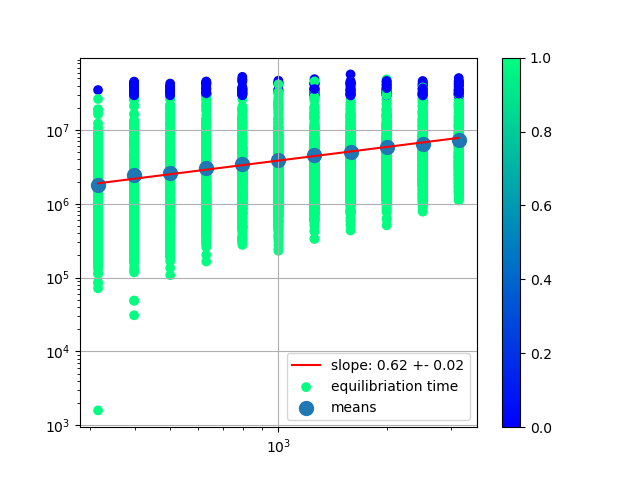

In [ ]:
from scipy.optimize import fsolve
kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)

fig, ax = plt.subplots()
L_fulls = np.array(L_fulls)
L_fulls_tilde = L_fulls[::num_repeat]
color_values_tilde = np.reshape(np.array(color_values), (num_repeat, len(color_values)//num_repeat), order='F')
color_values2_tilde = np.reshape(np.array(color_values2), (num_repeat, len(color_values2)//num_repeat), order='F')

tms_means = np.mean(color_values_tilde, axis=0, where=np.logical_and(color_values_tilde>1e3, color_values2_tilde))
tms_vars =   np.var(color_values_tilde, axis=0, where=np.logical_and(color_values_tilde>1e3, color_values2_tilde))

sc = ax.scatter(L_fulls, color_values, c=color_values2, cmap='winter', label='equilibriation time')
fig.colorbar(sc)
# ax.scatter(L_fulls, color_values2, alpha=0.3, label='final simulation time')
ax.scatter(L_fulls_tilde, tms_means, s=100, label='means')
# ax.fill_between(L_fulls_tilde, tms_means-np.sqrt(tms_vars/num_repeat), tms_means+np.sqrt(tms_vars/num_repeat), color='g', alpha=0.3)

from scipy.optimize import curve_fit
# slice = np.arange(len(L_fulls_tilde))#[:14]
(a, b), errs = curve_fit(lambda x, _a, _b :_a*x + _b, np.log(L_fulls_tilde), np.log(tms_means), p0=(-1.0, 10.0), sigma=np.sqrt(tms_vars/num_repeat))
ax.plot(L_fulls_tilde, np.exp(1)**(a * np.log(L_fulls_tilde) + b), 'r', label=f'slope: {a:.2f} +- {np.sqrt(errs[0, 0]):.2f}')
# ax.axvline(fsolve(lambda x: kappa * np.exp(-k * x) - kappa * np.exp(-k * x / 2) + eps * x / 2, 30)[0]-lower_stab, 0, 1, c='k', label='chaos existence') 
ax.legend()
ax.grid()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()


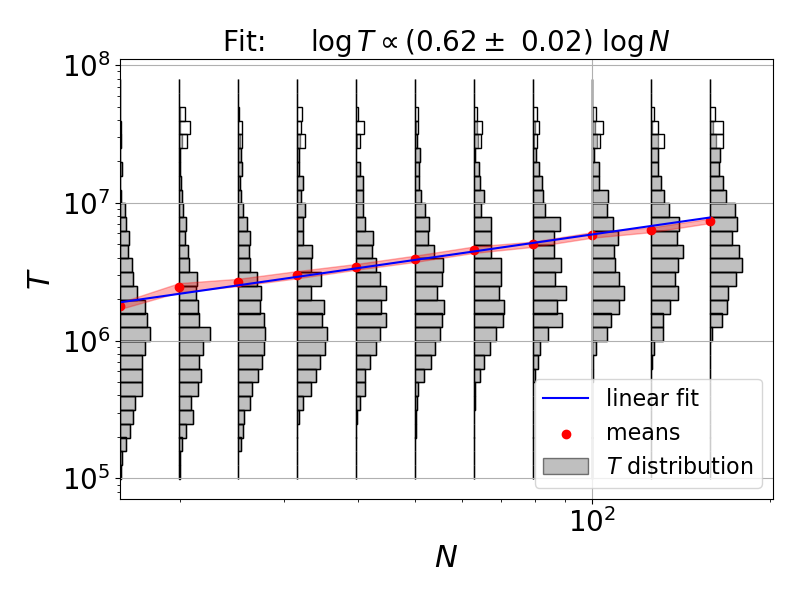

In [ ]:
plt.rcParams.update({
    'font.size': 18,          # Set the default font size for all elements
    'axes.titlesize': 20,     # Set the font size of the figure title
    'axes.labelsize': 22,     # Set the font size for the x and y labels
    'xtick.labelsize': 20,    # Set the font size for the x-axis tick labels
    'ytick.labelsize': 20,    # Set the font size for the y-axis tick labels
    'legend.fontsize': 16,    # Set the font size for the legend
    'figure.titlesize': 22    # Set the font size for the figure's main title
})
fig, ax = plt.subplots(figsize=(8,6))
for i in range(np.shape(color_values_tilde)[1]):
    mask = np.logical_and(color_values_tilde[:,i]>1e3, color_values2_tilde[:,i])
    _factor = 10000
    bin_edges = np.logspace(5.0,7.9, 30)
    bin_centers = np.sqrt(bin_edges[1:]*bin_edges[:-1])
    ax.barh(bin_centers, width=np.histogram(color_values_tilde[mask,i], bins=bin_edges)[0]*L_fulls_tilde[i]/_factor, left=L_fulls_tilde[i]/lbd_spl, height=np.diff(bin_edges), color='grey', alpha=0.5, edgecolor='k', zorder=-10, label='$T$ distribution' if i==0 else '')
    ax.barh(bin_centers, width=np.histogram(color_values_tilde[:   ,i], bins=bin_edges)[0]*L_fulls_tilde[i]/_factor, left=L_fulls_tilde[i]/lbd_spl, height=np.diff(bin_edges), color=(0, 0, 1, 0), edgecolor='k', zorder=-10)

ax.scatter(L_fulls_tilde/lbd_spl, tms_means, c='r', label='means')
ax.fill_between(L_fulls_tilde/lbd_spl, tms_means-np.sqrt(tms_vars/num_repeat), tms_means+np.sqrt(tms_vars/num_repeat), color='r', alpha=0.3)

from scipy.optimize import curve_fit
slice = np.arange(len(L_fulls_tilde))[:11]
(a, b), errs = curve_fit(lambda x, _a, _b :_a*x + _b, np.log10(L_fulls_tilde/lbd_spl)[slice], np.log10(tms_means)[slice], p0=(1.0, 5.0), sigma=np.sqrt(tms_vars/num_repeat)[slice])
ax.plot(L_fulls_tilde[slice]/lbd_spl, (L_fulls_tilde[slice]/lbd_spl)**a * 10**b, 'b', label=f'linear fit')
ax.set_ylabel('$T$')
ax.set_xlabel('$N$')
ax.set_title(f'Fit: \t $\log T \propto ({a:.2f} \pm$ {np.sqrt(errs[0][0]):.2f}) $\log N$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()



In [ ]:
np.histogram(color_values_tilde[mask,i], bins=bin_edges)[0]

array([ 2,  4, 11, 19, 27, 31, 45, 45, 44, 52, 61, 55, 52, 35, 26, 24, 16,
       18, 12, 10,  2,  0,  3,  0,  1,  0,  0,  0,  0])

In [ ]:
# phase diagram (eq time (success))

# system parameters
L_full = 1000   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
epsilon = 1e-1  # important
r = 1e-2        # important
# lbd_spl = 20.0  # important

# initial conditions
mu_fact = 0.95  # part of lbd_spl to start at
# sig = 5.0       # spread

# evolution parameters
n_steps = 10_000
dt = 1e6        # true dt is now adaptive. saving only at multiples of dt

# L_full_range = np.logspace(4.0, 2.0, 1, endpoint=True)
# epsilon_range = np.logspace(-2.0, 0.0, 7, endpoint=True)
lbd_spl_range = np.linspace(12.0, 30.0, 18, endpoint=True)
sig_range = [0.1, 3.0]

# params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt) for sig in sig_range for lbd_spl in lbd_spl_range for epsilon in epsilon_range]
params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt) for sig in sig_range for lbd_spl in lbd_spl_range]

epsilons, lbd_spls, sigs, color_values, color_values2 = [],[],[],[],[]

num_repeat = 1

for i, params in enumerate(params_list):#tqdm(enumerate(params_list), total=len(params_list)):#
    print(f"{i+1} / {len(params_list)}")
    for j in (range(num_repeat)):
        L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt = params
        np.random.seed(452999*i + 21321*j + 15)
        
        last_time, time_success = evolve_adapt_timestep_equi_time(*params, tqdm_bool=True, maxiter=100_000 if lbd_spl > lower_stab else 100, Nmax_fact=2.5)
        
        epsilons.append(epsilon)
        lbd_spls.append(lbd_spl)
        sigs.append(sig)
        color_values.append(last_time)
        color_values2.append(time_success)


1 / 36


Worst case timer: 100%|██████████| 100/100 [00:02<00:00, 46.68it/s]


2 / 36


Worst case timer: 100%|██████████| 100/100 [00:01<00:00, 52.65it/s]


3 / 36


Worst case timer:  64%|██████▍   | 63889/100000 [18:57<10:42, 56.17it/s]  


4 / 36


Worst case timer:   0%|          | 1/100000 [00:00<3:58:19,  6.99it/s]


5 / 36


Worst case timer:   0%|          | 0/100000 [00:00<?, ?it/s]


6 / 36


Worst case timer:   0%|          | 1/100000 [00:00<2:48:44,  9.88it/s]


7 / 36


Worst case timer:   0%|          | 1/100000 [00:00<2:44:21, 10.14it/s]


8 / 36


Worst case timer:   0%|          | 0/100000 [00:00<?, ?it/s]


9 / 36


Worst case timer:   0%|          | 0/100000 [00:00<?, ?it/s]


10 / 36


Worst case timer:   0%|          | 0/100000 [00:00<?, ?it/s]


11 / 36


Worst case timer:   0%|          | 1/100000 [00:00<2:03:59, 13.44it/s]


12 / 36


Worst case timer:   0%|          | 0/100000 [00:00<?, ?it/s]


13 / 36


Worst case timer:   0%|          | 1/100000 [00:00<5:58:05,  4.65it/s]


14 / 36


Worst case timer:   0%|          | 1/100000 [00:00<34:50, 47.84it/s]


15 / 36


Worst case timer:   0%|          | 1/100000 [00:00<44:54, 37.11it/s]


16 / 36


Worst case timer:   0%|          | 0/100000 [00:00<?, ?it/s]


17 / 36


Worst case timer:   0%|          | 0/100000 [00:00<?, ?it/s]


18 / 36


Worst case timer:   0%|          | 1/100000 [00:00<39:17, 42.43it/s]


19 / 36


Worst case timer: 100%|██████████| 100/100 [00:02<00:00, 42.50it/s]


20 / 36


Worst case timer: 100%|██████████| 100/100 [00:02<00:00, 48.67it/s]


21 / 36


Worst case timer:  96%|█████████▌| 96216/100000 [40:38<01:35, 39.46it/s]  


22 / 36


Worst case timer:  91%|█████████ | 90799/100000 [40:42<04:07, 37.17it/s]  


23 / 36


Worst case timer: 100%|██████████| 100000/100000 [42:22<00:00, 39.33it/s] 


24 / 36


Worst case timer: 100%|██████████| 100000/100000 [28:57<00:00, 57.56it/s] 


25 / 36


Worst case timer:  23%|██▎       | 22817/100000 [06:26<21:45, 59.11it/s]  


26 / 36


Worst case timer:   1%|          | 737/100000 [00:12<27:13, 60.77it/s]


27 / 36


Worst case timer:   0%|          | 385/100000 [00:06<28:36, 58.05it/s]


28 / 36


Worst case timer:   0%|          | 56/100000 [00:03<1:34:26, 17.64it/s]


29 / 36


Worst case timer:   0%|          | 11/100000 [00:00<59:19, 28.09it/s]  


30 / 36


Worst case timer:   0%|          | 15/100000 [00:00<1:06:49, 24.94it/s]


31 / 36


Worst case timer:   0%|          | 4/100000 [00:00<53:04, 31.40it/s]


32 / 36


Worst case timer:   0%|          | 2/100000 [00:00<1:02:31, 26.66it/s]


33 / 36


Worst case timer:   0%|          | 1/100000 [00:00<1:10:16, 23.72it/s]


34 / 36


Worst case timer:   0%|          | 1/100000 [00:00<1:07:13, 24.79it/s]


35 / 36


Worst case timer:   0%|          | 1/100000 [00:00<1:28:40, 18.80it/s]


36 / 36


Worst case timer:   0%|          | 1/100000 [00:00<1:09:38, 23.93it/s]


In [ ]:
np.save('epsilons.npy', np.array(epsilons))
np.save('lbd_spls.npy', np.array(lbd_spls))
np.save('sigs.npy', np.array(sigs))
np.save('color_values.npy', np.array(color_values))
np.save('color_values2.npy', np.array(color_values2))

In [ ]:
epsilons = np.load('epsilons.npy')
lbd_spls = np.load('lbd_spls.npy')
sigs = np.load('sigs.npy')
color_values = np.load('color_values.npy')
color_values2 = np.load('color_values2.npy')

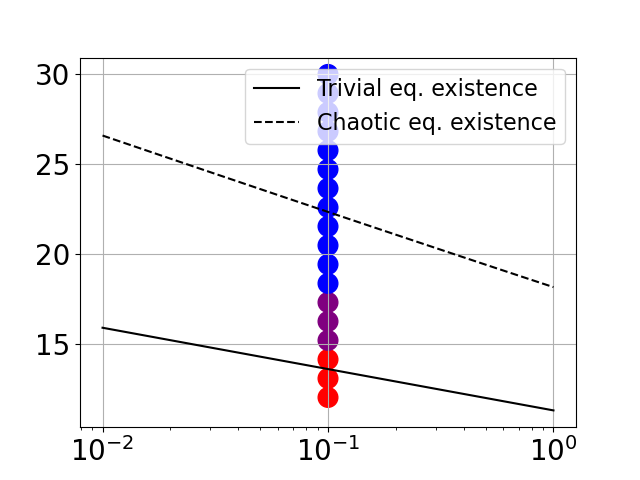

In [ ]:
fig, ax = plt.subplots()
c_red = np.array([1,0,0,1.0])
c_blu = np.array([0,0,1,1.0])
c_arr = np.array([c_blu if _c else c_red for _c in color_values2])
num_repeat = 1
c_arr = np.array([0.5*(c_arr[i] + c_arr[i+len(epsilons)//2]) for i in range(len(epsilons)//2)])
c_arr = np.array([np.mean(c_arr[num_repeat*i:num_repeat*(i+1)], axis=0) for i in range(len(epsilons)// 2 // num_repeat)])

ax.scatter(epsilons[0:len(epsilons)//2:num_repeat], lbd_spls[0:len(epsilons)//2:num_repeat], c=c_arr, s=200)
epsilon_array = np.logspace(-2, 0)
kappa, k, eps_array, _, _ = reparameterize(Drho, Dc, T, epsilon_array, r)
trivi_existence = -1/k * np.log(eps_array / k / kappa)
from scipy.optimize import fsolve
chaos_existence = np.asarray([fsolve(lambda x: kappa * np.exp(-k * x) - kappa * np.exp(-k * x / 2) + eps * x / 2, 30) for eps in eps_array]).flatten()
ax.plot(epsilon_array, trivi_existence,'k', label='Trivial eq. existence')
ax.plot(epsilon_array, chaos_existence,'k--', label='Chaotic eq. existence')
ax.legend()
ax.grid()
ax.set_xscale('log')
plt.show()


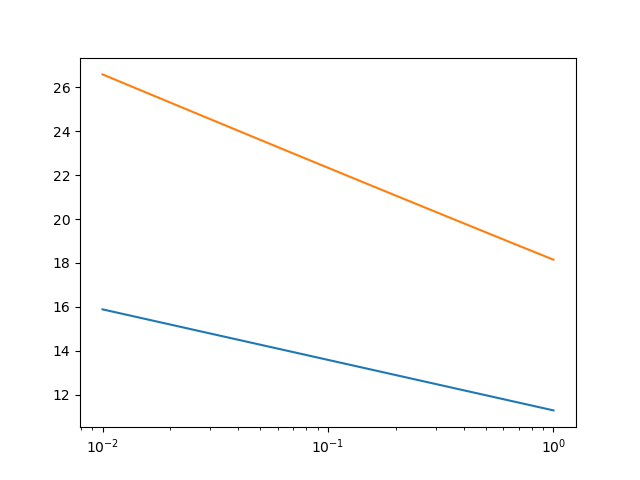

In [ ]:
epsilon_array = np.logspace(-2, 0)
kappa, k, eps_array, _, _ = reparameterize(Drho, Dc, T, epsilon_array, r)
from scipy.optimize import fsolve
chaos_existence = np.asarray([fsolve(lambda x: kappa * np.exp(-k * x) - kappa * np.exp(-k * x / 2) + eps * x / 2, 30) for eps in eps_array]).flatten()

fig, ax = plt.subplots()
ax.plot(epsilon_array, trivi_existence)
ax.plot(epsilon_array, chaos_existence)
ax.set_xscale('log')
plt.show()


In [ ]:
# evolve (adapt dt)
# system parameters
L_full = 45.0   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
epsilon = 1e-1  # important
r = 1e-2        # important
lbd_spl = 20.0  # important
kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
lbd_max = -1 / k * np.log(eps / k / kappa)
print(f'Emerging scales: {lbd_spl/2 = :.2f}, argmax v_M = {lbd_max:.2f}, {lbd_spl = :.2f}')

# initial conditions
mu_fact = 0.65  # part of lbd_spl to start at
sig = 15.0       # spread
# lbd_vect_ini, adj_matr_ini = get_initials(L_full, lbd_spl, mu_fact, sig, Nmax_fact=8)
# print(lbd_vect_ini)
# print(adj_matr_ini)

# # evolution parameters
n_steps = 100_000
dt = 1e2
print(f'Evolving on [0, {n_steps * dt:.0e}] with {dt = }, saving {n_steps} sample points. ')

np.random.seed(31121)

t_range, lbd_vect_t, adj_matr_t = evolve_adapt_timestep(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact / lbd_spl * L_full / 3, sig, n_steps, dt, Nmax_fact=10, maxiter=6_000)
evolve_adapt_timestep_equi_time(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact / lbd_spl * L_full / 3, sig, n_steps, dt, Nmax_fact=10, maxiter=6_000)


Emerging scales: lbd_spl/2 = 10.00, argmax v_M = 13.58, lbd_spl = 20.00
Evolving on [0, 1e+07] with dt = 100.0, saving 100000 sample points. 


Worst case timer:   1%|          | 33/6000 [00:00<01:19, 75.34it/s]


In [ ]:
# read off data and histogram animation
from os import listdir
filenames = [f for f in listdir('evol_data/') if (f[:9] == "lbdvectt_")]

# system parameters
L_full = 10000   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
# epsilon = 1e-2  # important
r = 1e-2        # important
# lbd_spl = 20.0  # important

# initial conditions
mu_fact = 0.85  # part of lbd_spl to start at
# sig = 5.0       # spread

# evolution parameters
n_steps = 100_000
dt = 1e1        # true dt is now adaptive. Save every dt

epsilon_range = np.logspace(-2, 0, 5, endpoint=True)
lbd_spl_range = np.linspace(12, 30, 7, endpoint=True)
sig_range     = [1.0, 5.0]

params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt) for lbd_spl in lbd_spl_range for epsilon in epsilon_range for sig in sig_range]
    
i = 26
# for params in tqdm(enumerate(params_list), total=len(params_list)):
params = params_list[i]
L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt = params
kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)

print(f'{epsilon = :.2e}, {lbd_spl = :.2f}')
lbd_vect_t = np.load(f'/scratch/n/Natan.Dominko/SIP_data/lbdvecttA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}.npy')
# adj_matr_t = np.load(f'/scratch/n/Natan.Dominko/SIP_data/adjmatrtA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}.npy', allow_pickle=True)
t_range = np.arange(0, n_steps*dt, dt)

last_ind = np.max(np.where(np.any(lbd_vect_t > 0, axis=0))[0])

n_bins_x = 30
bin_edges_x = np.linspace(0, 1.2 * lbd_spl, n_bins_x + 1, endpoint=True)
bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])

# find true last time
last_ind = np.max(np.where(np.any(lbd_vect_t > 0, axis=0))[0])
end_vals = lbd_vect_t[lbd_vect_t[:, last_ind] > 0, last_ind]
end_hist, _ = np.histogram(end_vals, bins=bin_edges_x, density=True)


epsilon = 3.16e-01, lbd_spl = 18.00


/home/n/Natan.Dominko/Documents/code/peaks_analysis/MFKSSteadyState.py:57: RuntimeWarning: overflow encountered in exp
  res = np.where((lbd > lbd_spl) & (lbd < lbd_inf), np.exp(-0.5*av_int.sol(lbd)), np.nan)


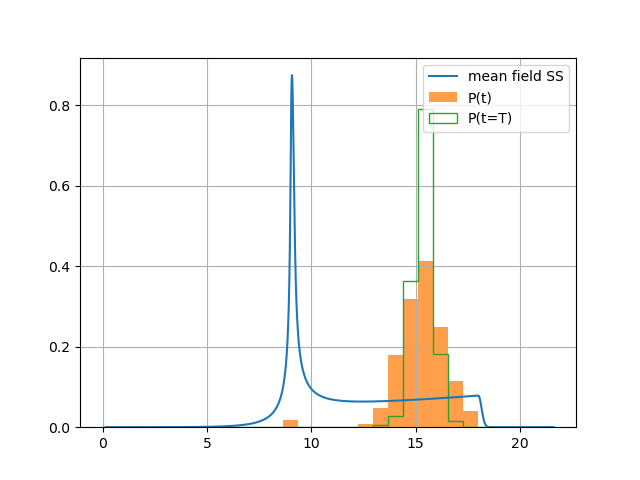

In [ ]:
from matplotlib.animation import FuncAnimation

# Step 1: Generate initial data
stride = 10
data = lbd_vect_t[:,0:stride].flatten()

# Step 2: Create the figure and axis
fig, ax = plt.subplots()
ax.grid()
from MFKSSteadyState import get_P_ss
xss, Pss = get_P_ss(1.2*lbd_spl, kappa, k, eps, lbd_spl, r)
ax.plot(xss, Pss, label='mean field SS')

# Create the initial histogram (the first frame)
n_bins = 30
bin_edges = np.linspace(0, 1.2 * lbd_spl, n_bins + 1, endpoint=True)
bin_center = 0.5 * (bin_edges[1:] + bin_edges[:-1])
hist, bin_edges, patches = ax.hist(data[data > 0], bins=bin_edges, density=True, alpha=0.75,  label='P(t)')

ax.hist(lbd_vect_t[lbd_vect_t > 0].flatten(), bins=bin_edges, density=True, histtype='step', label='P(t=T)')
ax.legend()

# Step 3: Define the update function for animation
def update(frame):
    new_data = lbd_vect_t[:,frame*stride:(frame+1)*stride].flatten()  # Generate new data for each frame
    new_hist_values, _ = np.histogram(new_data[new_data > 0], bins=bin_edges, density=True)  # Calculate new histogram values

    # Update the heights of the histogram bars
    for patch, new_height in zip(patches, new_hist_values):
        patch.set_height(new_height)

    ax.set_xlim([0, 1.2 * lbd_spl])  # Fix x-axis limits
    ax.set_ylim([0, 0.5])  # Fix y-axis limits
    ax.set_title(f'{epsilon = :.2e}, {lbd_spl = :.2f}, time: {stride * frame * dt:.2e}')  # Display the current frame number

# Step 4: Create the animation
ani = FuncAnimation(fig, update, frames=500, interval=100)

# Show the animated plot
plt.show()


In [ ]:
plt.close('all')

In [ ]:
# full (linearized) system near eq., eigvals
import numpy as np
def get_matr(N):
    A = np.zeros((N,N))
    for i in range(N):
        if i < N-1:
            A[i, i+1] += 1
            A[i, i] -= 1
        if i > 0:
            A[i, i-1] += 1
            A[i, i] -= 1
    return A
        
import matplotlib.pyplot as plt
%matplotlib widget
fig, ax = plt.subplots()
for N in [100]:
    matr = get_matr(N)
    matr[:,np.arange(N)>int(0.7 * N)] *= -0.6
    # matr[:,np.arange(N)%4==0] *= -2.6
    print(matr)
    ax.plot(np.linspace(0, 1-1/N, N), np.sort(np.linalg.eigvals(matr))[::-1], 'o-') # 2*(1 - np.cos(np.pi*np.linspace(0, 1-1/N, N)))
ax.plot(np.linspace(0, 1-1/100, 100), -2*(1 - np.cos(np.pi*np.linspace(0, 1-1/100, 100))), 'k-')
ax.plot(np.linspace(0, 1-1/100, 100), 0.6*2*(1 - np.cos(np.pi*np.linspace(0, 1-1/100, 100)))[::-1], 'r-')
ax.vlines(0.3, -3, 3, 'g')
ax.grid()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[[-1.   1.   0.  ... -0.  -0.  -0. ]
 [ 1.  -2.   1.  ... -0.  -0.  -0. ]
 [ 0.   1.  -2.  ... -0.  -0.  -0. ]
 ...
 [ 0.   0.   0.  ...  1.2 -0.6 -0. ]
 [ 0.   0.   0.  ... -0.6  1.2 -0.6]
 [ 0.   0.   0.  ... -0.  -0.6  0.6]]


In [ ]:
from scipy.stats import gaussian_kde
def KDE_with_error(data, x_eval, bandwidth, n_bootstraps):
    # Perform KDE
    kde = gaussian_kde(data, bw_method=bandwidth)
    pdf = kde.evaluate(x_eval)
    
    # Bootstrap to estimate the errors
    bootstrap_pdfs = np.zeros((n_bootstraps, len(x_eval)))
    
    for i in tqdm(range(n_bootstraps)):
        sample = np.random.choice(data, size=len(data), replace=True)
        kde_sample = gaussian_kde(sample, bw_method=bandwidth)
        bootstrap_pdfs[i, :] = kde_sample.evaluate(x_eval)
    
    # Calculate the standard error of the KDE estimates
    pdf_std_error = np.std(bootstrap_pdfs, axis=0)
    return pdf, pdf_std_error


In [ ]:
# phase diagram plots
from os import listdir
filenames = [f for f in listdir('evol_data/') if (f[:9] == "lbdvectt_")]
# print(f"Files in current directory: {filenames}")

fig, ax = plt.subplots()
epsilons = []    
lbd_spls = []
sigs = []
color_values = []
color_values2 = []
for filename in filenames:
    
    lbd_vect_t = np.load('evol_data/' + filename)
    param_strings = filename.split('_')
    epsilon = float(param_strings[1])
    lbd_spl = float(param_strings[2])
    L_full  = float(param_strings[3])
    mu_fact = float(param_strings[4])
    sig     = float(param_strings[5])
    n_steps = int(float(param_strings[6]))
    dt      = float(param_strings[7])
    stride_save = int(float(param_strings[8][:-4]))

    if n_steps != 1000000:
        continue

    n_bins_x = 30
    bin_edges_x = np.linspace(0, 1.2 * lbd_spl, n_bins_x + 1, endpoint=True)
    bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])

    end_vals = lbd_vect_t[lbd_vect_t[:, -1] > 0, -1]
    end_hist, _ = np.histogram(end_vals, bins=bin_edges_x, density=True)
    
    mean = np.trapz(end_hist * bin_center_x, bin_center_x)
    stdev= np.sqrt(np.trapz(end_hist * (mean - bin_center_x)**2, bin_center_x)) / lbd_spl
    # print(f'{epsilon = :.2e}, {lbd_spl = :.2f}, {stdev}')

    epsilons.append(epsilon)    
    lbd_spls.append(lbd_spl)
    sigs.append(sig)
    color_values.append(stdev)
    color_values2.append(np.sum((lbd_vect_t < 5) * (lbd_vect_t > 0)))

# scatter = ax.scatter(epsilons, [lbd_spls[i] + 0.5 * (sigs[i] - 1) / 4 for i in range(len(lbd_spls))], c=color_values, s=200, cmap='coolwarm')
# scatter = ax.scatter(epsilons, [lbd_spls[i] + 0.5 * (sigs[i] - 1) / 4 for i in range(len(lbd_spls))], c=[np.log(_l+1) for _l in color_values2], s=200, cmap='bwr')
scatter = ax.scatter(epsilons, lbd_spls, c=[(1,0,0,0.3) if _c > 0.1 else (0,0,1,0.3) for _c in color_values], s=200)
# fig.colorbar(scatter, ax=ax)
ax.grid()
ax.set_xscale('log')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'evol_data/'

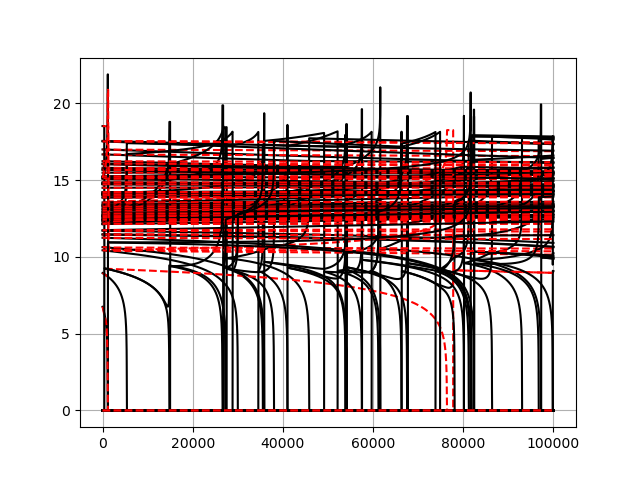

In [ ]:
fig, ax = plt.subplots()
for i in range(Nmax):
    ax.plot(t_range, lbd_vect_t[i, :], 'k-')
    ax.plot(t_range, lbd_vect_t_2[i, :], 'r--')
    # ax.plot(sol.t, sol.y[i, :], 'r--')
# ax.plot(t_range, np.sum(lbd_vect_t, axis=0))

ax.grid()
plt.show()

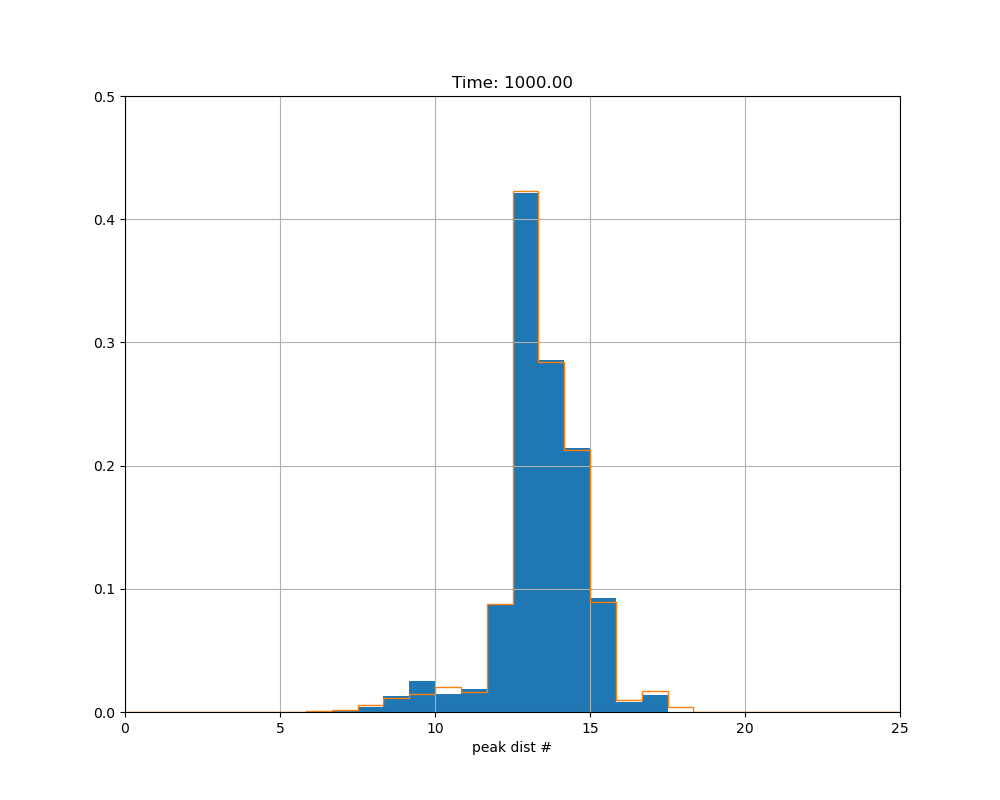

In [ ]:
n_bins_x = 30
bin_edges_x = np.linspace(0, 25, n_bins_x + 1, endpoint=True)
bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])


fig = plt.figure(figsize=(10,8))
k = 100
plt.hist(lbd_vect_t[lbd_vect_t > 0], bins=bin_edges_x, density=True)
plt.hist(lbd_vect_t_2[lbd_vect_t_2 > 0], bins=bin_edges_x, density=True, histtype='step')
# plt.plot(bin_center_x, KDE_with_error(lbd_vect_t[lbd_vect_t > 0], bin_center_x, bandwidth=None, n_bootstraps=100)[0])
plt.title(f'Time: {t_range[k]:.2f}')
plt.xlabel('peak dist #')
plt.xlim(0, 25)
plt.ylim(0, 0.5)
plt.grid()
plt.show()

In [ ]:
plt.close('all')
print(np.shape(lbd_vect_t))

(66, 1000)


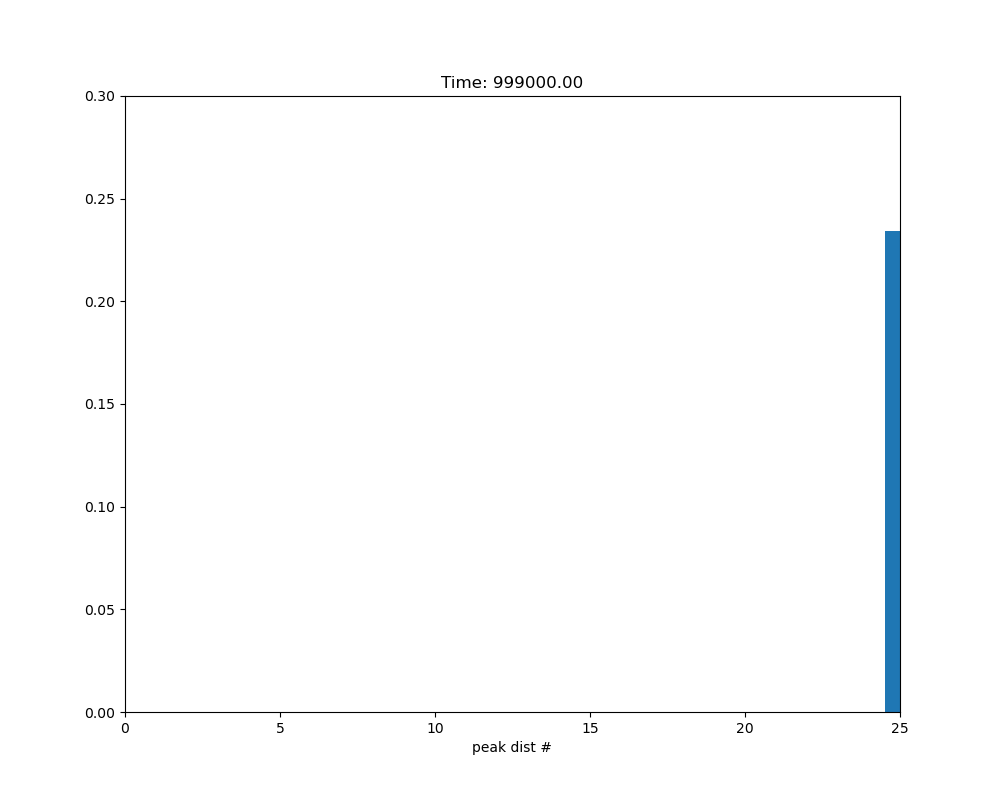

No such comm: 9daeca8d9d04430387f650d5ecc84eb2


In [ ]:
n_bins_x = 40
bin_edges_x = np.linspace(0, 35, n_bins_x + 1, endpoint=True)
bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])

from matplotlib.animation import FuncAnimation

# Animation function
plt.close('all')
def animate(k):
    plt.cla()
    plt.hist(lbd_vect_t[lbd_vect_t[:, k] > 0, k], bins=bin_edges_x, density=True)
    # plt.plot(bin_center_x, KDE_with_error(lbd_vect_t[lbd_vect_t[:, k] > 0, k], bin_center_x, bandwidth=None, n_bootstraps=100)[0])
    plt.title(f'Time: {t_range[k]:.2f}')
    plt.xlabel('peak dist #')
    plt.xlim(0, 25)
    plt.ylim(0, 0.3)

# Create animation
fig = plt.figure(figsize=(10,8))
ani = FuncAnimation(fig, animate, frames=n_steps // stride_save, interval=1)
ani.save('distances_hist_model4.gif', writer='imagemagick', fps=10)# Display animation
# plt.show()

## Trash

In [ ]:
# functions (fixed timestep)
def rhs(lbd_vect, adj_matr, kappa, k, eps):
    return adj_matr @ g(lbd_vect, kappa, k, eps)

def step(lbd_vect, adj_matr, random_uniform, dt, kappa, k, eps, lbd_spl, r):
    # handle splitting
    potential_split_inds = np.where(lbd_vect > lbd_spl)[0]
    for i, potential_split_ind in enumerate(potential_split_inds):
        if random_uniform.get_next() < dt * r * (lbd_vect[potential_split_ind] - lbd_spl):
            lbd_vect, adj_matr = split(potential_split_ind, lbd_vect, adj_matr)
    # handle dynamics
    lbd_vect_tilde = lbd_vect + dt * rhs(lbd_vect, adj_matr, kappa, k, eps)   
    return fix_negative(lbd_vect_tilde, adj_matr)

def evolve_fixed_timestep(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt, stride_save, tqdm_bool=True):
    kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)

    # initial conditions
    lbd_vect_ini, adj_matr_ini = get_initials(L_full, lbd_spl, mu_fact, sig)
    Nmax = len(lbd_vect_ini)
    
    # initialize variables
    t_range = np.arange(0, dt * n_steps, dt * stride_save)
    lbd_vect_t = np.zeros((Nmax, n_steps // stride_save))
    adj_matr_t = np.zeros((n_steps // stride_save), dtype=object)
    lbd_vect_t[:, 0] = lbd_vect_ini
    adj_matr_t[0] = adj_matr_ini
    lbd_vect, adj_matr = lbd_vect_ini, adj_matr_ini
    random_uniform_array = PrecompiledRandomGenerator(10_000_000)

    # evolve
    _iter = tqdm(range(1, n_steps)) if tqdm_bool else range(1, n_steps)
    for i in _iter:
        lbd_vect, adj_matr = step(lbd_vect, adj_matr, random_uniform_array,  dt, kappa, k, eps, lbd_spl, r)
        # save at some steps
        if i % stride_save == 0:
            # make sure adj matrix is sparse 
            adj_matr = csr_matrix(adj_matr.toarray())
            lbd_vect_t[:, i//stride_save] = lbd_vect
            adj_matr_t[   i//stride_save] = adj_matr
    
    return t_range, lbd_vect_t, adj_matr_t


In [ ]:
# evolve (fixed dt)

# system parameters
L_full = 1000   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
epsilon = 1e-2  # important
r = 1e-2        # important
lbd_spl = 20.0  # important
kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
lbd_max = -1 / k * np.log(eps / k / kappa)
print(f'Emerging scales: {lbd_spl/2 = :.2f}, argmax v_M = {lbd_max:.2f}, {lbd_spl = :.2f}')

# initial conditions
mu_fact = 0.85  # part of lbd_spl to start at
sig = 5.0       # spread
lbd_vect_ini, adj_matr_ini = get_initials(L_full, lbd_spl, mu_fact, sig)
Nmax = len(lbd_vect_ini)
print(f'Simulation supports at most {Nmax} plateaus. ')

# evolution parameters
n_steps = 1_000_000 
dt = 1e0
stride_save = 100
print(f'Evolving on [0, {n_steps * dt:.0e}] with {dt = }, saving {n_steps // stride_save} sample points. ')

t_range, lbd_vect_t, adj_matr_t = evolve_fixed_timestep(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt, stride_save)

Emerging scales: lbd_spl/2 = 10.00, argmax v_M = 15.88, lbd_spl = 20.00
Simulation supports at most 100 plateaus. 
Evolving on [0, 1e+06] with dt = 1.0, saving 10000 sample points. 


100%|██████████| 999999/999999 [00:28<00:00, 34580.55it/s]


NameError: name 'lbd_vect_t' is not defined

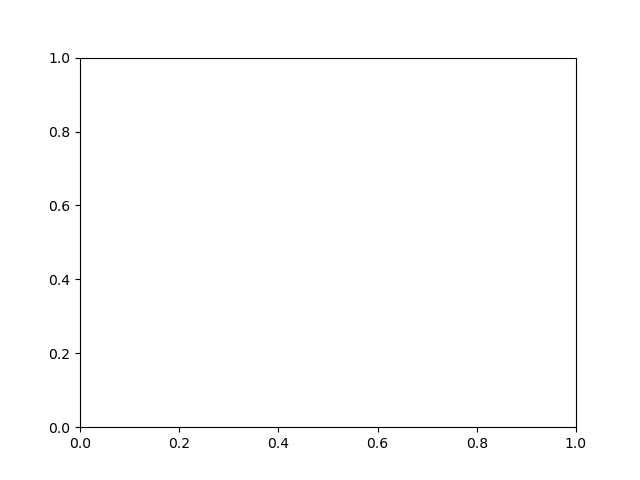

In [ ]:
# plot solution 
fig, ax = plt.subplots()
assert np.all(np.isclose(np.sum(lbd_vect_t, axis=0), L_full))
for i in range(Nmax):
    ax.plot(t_range, lbd_vect_t[i, :])
ax.grid()
plt.show()

In [ ]:
# evolve (fixed dt) - parameter sweep

# system parameters
L_full = 1000   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
# epsilon = 1e-2  # important
r = 1e-2        # important
# lbd_spl = 20.0  # important

# initial conditions
mu_fact = 0.85  # part of lbd_spl to start at
# sig = 5.0       # spread

# evolution parameters
n_steps = 1_000_000
dt = 1e0
stride_save = 1_000

epsilon_range = np.logspace(-2, 0, 5, endpoint=True)
lbd_spl_range = np.linspace(12, 30, 7, endpoint=True)
sig_range     = [1.0, 5.0]

params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt, stride_save) for lbd_spl in lbd_spl_range for epsilon in epsilon_range for sig in sig_range]

save_bool = False
for i, params in tqdm(enumerate(params_list), total=len(params_list)):
    t_range, lbd_vect_t, adj_matr_t = evolve_fixed_timestep(*params, tqdm_bool=False)
    if save_bool:
        L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt, stride_save = params
        # np.save(f'evol_data/lbdvectt_{epsilon:.2e}_{lbd_spl:.2f}_{L_full:.0f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}_{stride_save:.0e}.npy', lbd_vect_t)
        # np.save(f'evol_data/adjmatrt_{epsilon:.2e}_{lbd_spl:.2f}_{L_full:.0f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}_{stride_save:.0e}.npy', adj_matr_t)


  0%|          | 0/70 [00:00<?, ?it/s]/usr/lib64/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|██████████| 70/70 [00:07<00:00,  9.70it/s]


In [ ]:
# def get_ordering(adj_matr, order_old):
#     Nmax = np.shape(adj_matr)[0]
#     order_new = -np.ones_like(order_old)
#     neighbor_inds = sparse_find_neighbors(adj_matr, order_old[0])
#     # edge selection
#         # if previous edge is still edge, select it to start
#         # elif one of her neighbors is edge, select it to start
#         # else choose one randomly
#     if len(neighbor_inds) == 1:
#         order_new[0] = order_old[0]
#     elif len(neighbor_inds) == 2:
#         if len(sparse_find_neighbors(adj_matr, neighbor_inds[0])) == 1:
#             order_new[0] = neighbor_inds[0]
#         elif len(sparse_find_neighbors(adj_matr, neighbor_inds[1])) == 1:
#             order_new[0] = neighbor_inds[1]
#         else:
#             raise ValueError
#     elif len(neighbor_inds) == 0:
#         order_new[0] = order_old[1]
#     else: # fix this
#         raise ValueError
        
#     current_ind = sparse_find_neighbors(adj_matr, order_new[0])[0]
#     current_neighbor_inds = sparse_find_neighbors(adj_matr, current_ind)
#     for i in range(1, Nmax):
#         order_new[i] = current_ind
#         if len(current_neighbor_inds) == 1:
#             order_new[i+1:] = [ind for ind in np.arange(Nmax) if ind not in order_new[:i+1]]
#             break
#         else:
#             current_ind = [neighbor_ind for neighbor_ind in current_neighbor_inds if neighbor_ind != order_new[i-1]][0]
#             current_neighbor_inds = sparse_find_neighbors(adj_matr, current_ind)

#     return order_new

# def check_already_ordered(adj_matr, order):
#     must_be_tridiag = adj_matr.toarray()[np.ix_(order, order)]
#     if np.all(np.triu(must_be_tridiag, 2) == 0.0):
#         return True
#     else:
#         return False

# def reorder_particles(lbd_vect_t, adj_matr_t):
#     Nmax = np.shape(adj_matr_t[0])[0]
#     order_t = np.zeros_like(lbd_vect_t, dtype=int)
#     lbd_vect_t_reorder = np.zeros_like(lbd_vect_t)
#     order_t[:, 0] = get_ordering(adj_matr_t[0], order_old=np.arange(Nmax, dtype=int))
#     lbd_vect_t_reorder[:, 0] = lbd_vect_t[order_t[:, 0], 0]
#     for i in tqdm(range(1, n_steps)):
#         already_ordered = False#check_already_ordered(adj_matr_t[i], order_t[:, i-1])
#         if already_ordered: # edge state
#             order_t[:, i] = order_t[:, i-1]
#         else:
#             order_t[:, i] = get_ordering(adj_matr_t[i], order_old=order_t[:, i-1])

#         lbd_vect_t_reorder[:, i] = lbd_vect_t[order_t[:, i], i]
#     return lbd_vect_t_reorder


In [ ]:
# 3d case with fixed 1st and 3rd coordinate
def get_ordering(adj_matr, lbd_vect, order_old):
    start_ind, end_ind = np.argwhere(adj_matr.diagonal() == -1).T[0]
    order_new = -np.ones_like(order_old)
    if start_ind == order_old[0] or end_ind == order_old[2]:
        order_new[0] = start_ind
        order_new[2] = end_ind
    else:
        order_new[0] = end_ind
        order_new[2] = start_ind
    lbd_vect_temporary = lbd_vect.copy()
    lbd_vect_temporary[[start_ind, end_ind]] = -np.inf
    mid_ind = np.argmax(lbd_vect_temporary)
    order_new[1] = mid_ind

    order_new[3:] = [ind for ind in np.arange(len(lbd_vect)) if ind not in order_new[:3]]

    return order_new

# def check_already_ordered(adj_matr, order):
#     must_be_tridiag = adj_matr.toarray()[np.ix_(order, order)]
#     if np.all(np.triu(must_be_tridiag, 2) == 0.0):
#         return True
#     else:
#         return False

def reorder_particles(lbd_vect_t, adj_matr_t, tqdm_bool=True):
    Nmax = np.shape(adj_matr_t[0])[0]
    order_t = np.zeros_like(lbd_vect_t, dtype=int)
    lbd_vect_t_reorder = np.zeros_like(lbd_vect_t)
    order_t[:, 0] = get_ordering(adj_matr_t[0], lbd_vect_t[:, 0], order_old=-np.ones(Nmax, dtype=int))
    lbd_vect_t_reorder[:, 0] = lbd_vect_t[order_t[:, 0], 0]
    iter = tqdm(range(1, np.shape(lbd_vect_t)[1])) if tqdm_bool else range(1, np.shape(lbd_vect_t)[1])
    for i in iter:
        order_t[:, i] = get_ordering(adj_matr_t[i], lbd_vect_t[:, i], order_old=order_t[:, i-1])
        lbd_vect_t_reorder[:, i] = lbd_vect_t[order_t[:, i], i]
        
    return lbd_vect_t_reorder


/tmp/ipykernel_3068990/1566611882.py:14: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(X, Y, Z, alpha=0.4)


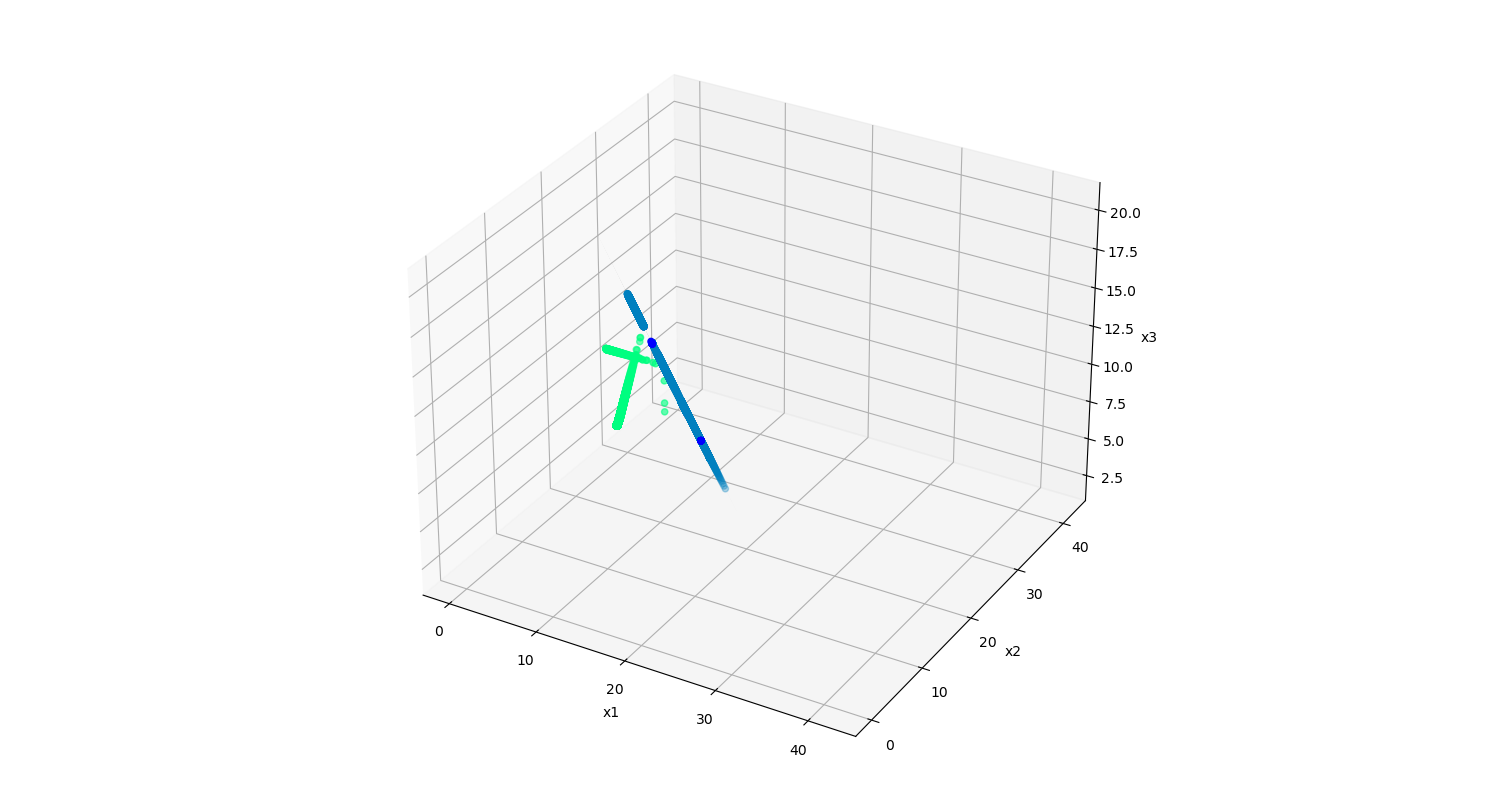

In [ ]:
# 3d plot of the 3 state trajectory
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(np.linspace(0, L_full, 100), np.linspace(0, L_full, 100))
Z = L_full - X - Y
Z[Z < 0] = np.nan  # This will leave out the invalid parts of the surface
Z[X > lbd_spl] = np.nan  # This will leave out the invalid parts of the surface
Z[Y > lbd_spl] = np.nan  # This will leave out the invalid parts of the surface
Z[L_full - X - Y > lbd_spl] = np.nan  # This will leave out the invalid parts of the surface
ax.plot_surface(X, Y, Z, alpha=0.4)
time_slice = np.arange(n_steps)[int(n_steps*0.5):int(n_steps*0.5) + 500000]
cbar = ax.scatter3D(lbd_vect_t[0, time_slice], lbd_vect_t[1, time_slice], lbd_vect_t[2, time_slice], c=[np.sum(lbd_vect_t[:, i] != 0.0) for i in time_slice], cmap='winter')
# cbar = ax.plot3D(lbd_vect_t[0, time_slice], lbd_vect_t[1, time_slice], lbd_vect_t[2, time_slice])
# fig.colorbar(cbar)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
plt.tight_layout()
plt.show()

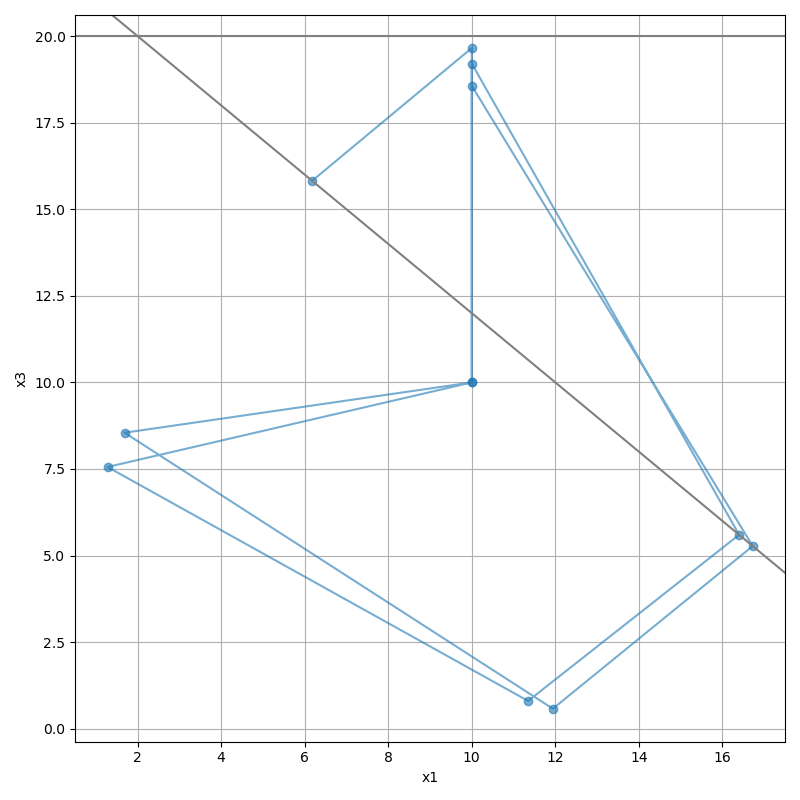

In [ ]:
# project to a 2D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
time_slice = np.arange(12)#np.arange(n_steps)[int(n_steps*0.0):int(n_steps*1.0):1]
colors = np.array([np.sum(lbd_vect_t[:, i] != 0.0) for i in time_slice])

# ax.plot(lbd_vect_t[0, time_slice][colors == 3], lbd_vect_t[2, time_slice][colors == 3], '-o')
ax.plot(lbd_vect_t[0, time_slice], lbd_vect_t[2, time_slice], '-o', alpha=0.6)
# ax.scatter(lbd_vect_t[0, time_slice][colors == 3], lbd_vect_t[2, time_slice][colors == 3])
# ax.scatter(lbd_vect_t[0, time_slice], lbd_vect_t[2, time_slice], c=[np.sum(lbd_vect_t[:, i] != 0.0) for i in time_slice], cmap='winter')
ax.set_xlabel('x1')
ax.set_ylabel('x3')
ax.grid()
# ax.set_aspect('equal')
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.plot(np.linspace(0, L_full), L_full - lbd_spl-np.linspace(0, L_full), 'grey')
ax.plot(np.linspace(0, L_full), lbd_spl*np.ones_like(np.linspace(0, L_full)), 'grey')
ax.axvline(lbd_spl, 0, 1, c='grey')
ax.set_xlim(*xlim), ax.set_ylim(*ylim) 
plt.tight_layout()
plt.show()

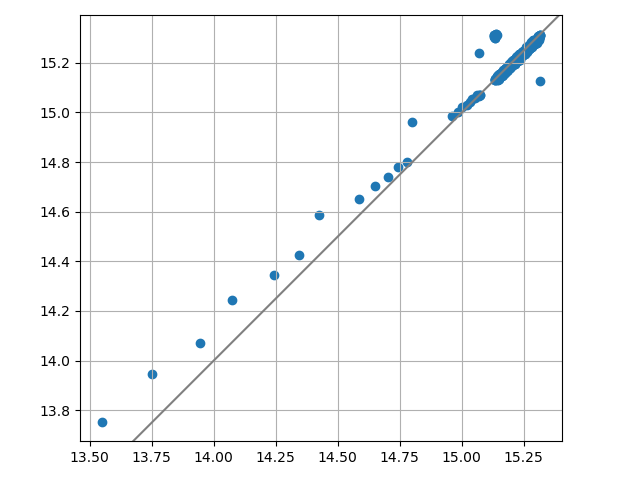

In [ ]:
# poincare
close_inds = np.where(np.isclose(lbd_vect_t[2, :], lbd_spl, atol=0.05))[0]
true_inds = [ind for ind in close_inds if ((lbd_vect_t[2, ind-1] > 0.9 * lbd_spl) and (np.sum(lbd_vect_t[:, i] != 0.0) == 3))]
fig, ax = plt.subplots()
ax.scatter(lbd_vect_t[0, true_inds[:-1]], lbd_vect_t[0, true_inds[1:]])
ax.grid()
ax.set_aspect('equal')
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.plot(np.linspace(xlim[0], xlim[1]), np.linspace(xlim[0], xlim[1]), 'grey')
ax.set_xlim(*xlim), ax.set_ylim(*ylim) 
plt.tight_layout()
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]/usr/lib64/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|██████████| 500/500 [16:34<00:00,  1.99s/it]


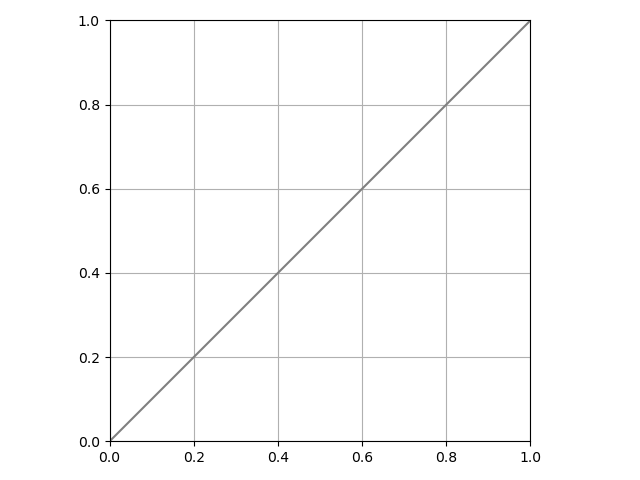

In [ ]:
sig = 10
n_steps = 20000
fig, ax = plt.subplots()
ar = []
for i in tqdm(range(500)):
    try:
        np.random.seed(i+140)
        _, _, _,t_range, lbd_vect_t, adj_matr_t = evolve_adapt_timestep_hard_split(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact / lbd_spl * L_full / 3, sig, n_steps, dt, Nmax_fact=4, maxiter=6_000, tqdm_bool=False)
        lbd_vect_t = reorder_particles(lbd_vect_t, adj_matr_t, tqdm_bool=False)
        close_inds = np.where(np.isclose(lbd_vect_t[2, :], lbd_spl/2, atol=0.00001))[0]
        # close_inds2 = np.where(np.isclose(lbd_vect_t[0, :], lbd_spl/2, atol=0.00001))[0]
        ar += list(lbd_vect_t[0, close_inds])
        # ax.scatter(lbd_vect_t[0, close_inds[:-1]], lbd_vect_t[0, close_inds[1:]], c='k')
        # ax.scatter(lbd_vect_t[2, close_inds2[:-1]], lbd_vect_t[2, close_inds2[1:]])
    except:
        pass
ax.grid()
ax.set_aspect('equal')
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.plot(np.linspace(xlim[0], xlim[1]), np.linspace(xlim[0], xlim[1]), 'grey')
ax.set_xlim(*xlim), ax.set_ylim(*ylim) 
plt.tight_layout()
plt.show()

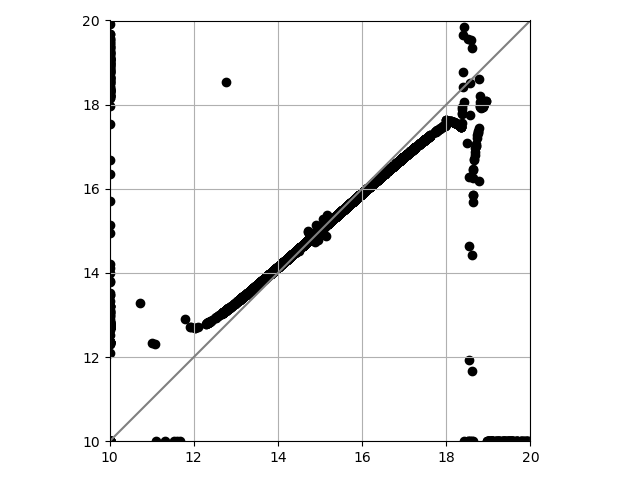

In [ ]:
# poincare better
fig, ax = plt.subplots()
xx = np.array(ar[:-1])
yy = np.array(ar[1:])
mask = ~(np.logical_and(np.abs(xx - 15.0) < 2, np.abs(xx - yy) > 0.3))
ax.scatter(xx[mask], yy[mask], c='k')
ax.grid()
ax.set_aspect('equal')
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.plot(np.linspace(xlim[0], xlim[1]), np.linspace(xlim[0], xlim[1]), 'grey')
ax.set_xlim(*xlim), ax.set_ylim(*ylim) 
ax.set_xlim(10, 20), ax.set_ylim(10, 20) 
plt.tight_layout()
plt.show()